In [1]:
import sys
import warnings

sys.path.append("../")
warnings.filterwarnings("ignore")

# set working directory to root 
import os
os.chdir("../")
root = os.getcwd()
# root = root + "/workspaces/mine-segmentation" # for lightning studios
print(f"Root directory: {root}")

Root directory: /home/simonjasansky/programming/mine-segmentation


In [2]:
import numpy as np
import pandas as pd
import torch
from PIL import Image
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import SemanticSegmentationTarget
# from torchviz import make_dot


from src.models.datamodule import MineDataModule
from src.models.cnn.model import MineSegmentorCNN
from src.models.clay.segment.model import MineSegmentor

from src.visualization.visualization_funcs import plot_pred_vs_true_mask

In [3]:
# for development
%load_ext autoreload
%autoreload 2

In [4]:
# # 2048 model
# MINESEG_CHECKPOINT_PATH = ("models/cnn/2048_mineseg-cnn_epoch-08_val-iou-0.5017.ckpt")
# CHIP_SIZE = 2048
# TESTSET_BATCH_SIZE = 1
# TRAIN_CHIP_DIR = "data/processed/chips/npy/2048/train/chips/"
# TRAIN_LABEL_DIR = " data/processed/chips/npy/2048/train/labels/"
# VAL_CHIP_DIR = "data/processed/chips/npy/2048/val/chips/"
# VAL_LABEL_DIR = "data/processed/chips/npy/2048/val/labels/"
# TEST_CHIP_DIR = "data/processed/chips/npy/2048/test/chips/"
# TEST_LABEL_DIR = "data/processed/chips/npy/2048/test/labels/"
# METADATA_PATH = "configs/cnn/cnn_segment_metadata.yaml"
# CLAY = False


# # 1024 model
# MINESEG_CHECKPOINT_PATH = ("models/cnn/1024_mineseg-cnn_epoch-15_val-iou-0.5290.ckpt")
# CHIP_SIZE = 1024
# TESTSET_BATCH_SIZE = 4
# TRAIN_CHIP_DIR = "data/processed/chips/npy/1024/train/chips/"
# TRAIN_LABEL_DIR = " data/processed/chips/npy/1024/train/labels/"
# VAL_CHIP_DIR = "data/processed/chips/npy/1024/val/chips/"
# VAL_LABEL_DIR = "data/processed/chips/npy/1024/val/labels/"
# TEST_CHIP_DIR = "data/processed/chips/npy/1024/test/chips/"
# TEST_LABEL_DIR = "data/processed/chips/npy/1024/test/labels/"
# METADATA_PATH = "configs/cnn/cnn_segment_metadata.yaml"
# CLAY = False


# # 512 model
# MINESEG_CHECKPOINT_PATH = ("models/cnn/mineseg-cnn_epoch-16_val-iou-0.5731.ckpt")
# CHIP_SIZE = 512
# TESTSET_BATCH_SIZE = 16 # 32 for L4, 16 for PC GPU
# TRAIN_CHIP_DIR = "data/processed/chips/npy/512/train/chips/"
# TRAIN_LABEL_DIR = "data/processed/chips/npy/512/train/labels/"
# VAL_CHIP_DIR = "data/processed/chips/npy/512/val/chips/"
# VAL_LABEL_DIR = "data/processed/chips/npy/512/val/labels/"
# TEST_CHIP_DIR = "data/processed/chips/npy/512/test/chips/"
# TEST_LABEL_DIR = "data/processed/chips/npy/512/test/labels/"
# METADATA_PATH = "configs/cnn/cnn_segment_metadata.yaml"
# CLAY = False


# CLAY model
MINESEG_CHECKPOINT_PATH = "models/clay/mineseg-clay-segment_epoch-00_val-iou-0.3156.ckpt"
CLAY_CHECKPOINT_PATH = "models/clay-v1-base.ckpt"
CHIP_SIZE = 512
TESTSET_BATCH_SIZE = 1
TRAIN_CHIP_DIR = "data/processed/chips/npy/512/train/chips/"
TRAIN_LABEL_DIR = "data/processed/chips/npy/512/train/labels/"
VAL_CHIP_DIR = "data/processed/chips/npy/512/val/chips/"
VAL_LABEL_DIR = "data/processed/chips/npy/512/val/labels/"
TEST_CHIP_DIR = "data/processed/chips/npy/512/test/chips/"
TEST_LABEL_DIR = "data/processed/chips/npy/512/test/labels/"
METADATA_PATH = "configs/clay/clay_segment_metadata.yaml"
CLAY = True


# general setup
DATASET = "data/processed/mining_tiles_with_masks_and_bounding_boxes.gpkg"
BATCH_SIZE = 1
if torch.cuda.is_available():
    NUM_WORKERS = 16
else:
    NUM_WORKERS = 4
PLATFORM = "sentinel-2-l2a"

In [5]:
if CLAY:
    CLAY_CHECKPOINT_PATH = root + "/" + CLAY_CHECKPOINT_PATH

MINESEG_CHECKPOINT_PATH = root + "/" + MINESEG_CHECKPOINT_PATH
METADATA_PATH = root + "/" + METADATA_PATH
TRAIN_CHIP_DIR = root +  "/" + TRAIN_CHIP_DIR
TRAIN_LABEL_DIR = root + "/" + TRAIN_LABEL_DIR
VAL_CHIP_DIR = root + "/" + VAL_CHIP_DIR
VAL_LABEL_DIR = root + "/" + VAL_LABEL_DIR
TEST_CHIP_DIR = root + "/" + TEST_CHIP_DIR
TEST_LABEL_DIR = root + "/" + TEST_LABEL_DIR
DATASET = root + "/" + DATASET

In [6]:
if CLAY:
    def get_model(mineseg_checkpoint_path, clay_checkpoint_path, metadata_path):
        model = MineSegmentor.load_from_checkpoint(
            checkpoint_path=mineseg_checkpoint_path,
            metadata_path=metadata_path,
            ckpt_path=clay_checkpoint_path,
        )
        model.eval()
        return model
else: 
    def get_model(checkpoint_path: str) -> MineSegmentorCNN:
        # check if gpu is available
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {device}")
        map_location=torch.device(device)
        checkpoint = torch.load(checkpoint_path, map_location=map_location)
        model_config = checkpoint["hyper_parameters"]
        model = MineSegmentorCNN.load_from_checkpoint(checkpoint_path, **model_config)
        model.eval()
        return model

In [7]:
def get_data(
    train_chip_dir,
    train_label_dir,
    val_chip_dir,
    val_label_dir,
    test_chip_dir,
    test_label_dir,
    metadata_path,
    batch_size,
    num_workers,
    platform,
    data_augmentation,
    index=None
):
    dm = MineDataModule(
        train_chip_dir=train_chip_dir,
        train_label_dir=train_label_dir,
        val_chip_dir=val_chip_dir,
        val_label_dir=val_label_dir,
        test_chip_dir=test_chip_dir,
        test_label_dir=test_label_dir,
        metadata_path=metadata_path,
        batch_size=batch_size,
        num_workers=num_workers,
        platform=platform,
        data_augmentation=data_augmentation,
    )
    
    dm.setup(stage="test")
    
    if index is not None:
        test_dl = iter(dm.test_dataloader())
        for i in range(index + 1):
            batch = next(test_dl)
        metadata = dm.metadata
        return batch, metadata
    else:
        test_dl = dm.test_dataloader()
        batch = next(iter(test_dl))
        metadata = dm.metadata
        return batch, metadata

In [8]:
def post_process(batch, outputs, metadata, index=0):
    
    outputs = outputs.sigmoid()
    prob_mask = outputs.detach().cpu().numpy()
    pred_mask = (prob_mask > 0.5).astype(float)
    labels = batch["label"].detach().cpu().numpy()
    pixels = batch["pixels"].detach().cpu().numpy()

    # normalize and clip the image ranges
    pixels = (pixels - pixels.min()) / (pixels.max() - pixels.min())
    pixels = np.clip(pixels, 0, 1)

    images = pixels[index]
    labels = labels[index]
    prob_mask = prob_mask[index]
    pred_mask = pred_mask[index].astype(float)

    images = images.transpose((1,2,0))
    prob_mask = prob_mask.transpose((1,2,0))
    pred_mask = pred_mask.transpose((1,2,0)).astype(float)

    return images, labels, prob_mask, pred_mask

In [9]:
# Load model
if CLAY:
    model = get_model(MINESEG_CHECKPOINT_PATH, CLAY_CHECKPOINT_PATH, METADATA_PATH)
else:
    model = get_model(MINESEG_CHECKPOINT_PATH)

In [10]:
import random
test_chips = os.listdir(TEST_CHIP_DIR)
test_chips_indices = [test_chips.index(chip) for chip in test_chips]
test_chips_wo_miningarea = [chip for chip in test_chips if "nominearea" in chip]
test_chips_w_miningarea = [chip for chip in test_chips if "nominearea" not in chip]
indices_wo_miningarea = [test_chips.index(chip) for chip in test_chips_wo_miningarea]
indices_w_miningarea = [test_chips.index(chip) for chip in test_chips_w_miningarea]

print(f"Number of all test chips: {len(test_chips)}")
print(f"Number of test chips without mining area: {len(test_chips_wo_miningarea)}")
print(f"Number of test chips with mining area: {len(test_chips_w_miningarea)}")

# take a sample of the chips with mining area 
# random.seed(42)
sample_indices_w_ma = random.sample(indices_w_miningarea, 4)
print(f"Sample indices of chips with mining area: {sample_indices_w_ma}")
if not CHIP_SIZE == 2048:
    sample_indices_wo_ma = random.sample(indices_wo_miningarea, 4)
    print(f"Sample indices of chips without mining area: {sample_indices_wo_ma}")

Number of all test chips: 1843
Number of test chips without mining area: 1062
Number of test chips with mining area: 781
Sample indices of chips with mining area: [76, 583, 1486, 235]
Sample indices of chips without mining area: [576, 1013, 1269, 464]


In [11]:
batch, metadata = get_data(
    train_chip_dir=TRAIN_CHIP_DIR,
    train_label_dir=TRAIN_LABEL_DIR,
    val_chip_dir=VAL_CHIP_DIR,
    val_label_dir=VAL_LABEL_DIR,
    test_chip_dir=TEST_CHIP_DIR,
    test_label_dir=TEST_LABEL_DIR,
    metadata_path=METADATA_PATH,
    batch_size=1,
    num_workers=NUM_WORKERS,
    platform=PLATFORM,
    data_augmentation=False,
    index=534
)

# Move batch to GPU
if torch.cuda.is_available():
    batch = {k: v.to("cuda") for k, v in batch.items()}

In [12]:
def visualize_cam(batch, target_layers, isclay=False):
    target_layers = [target_layers]
    with torch.no_grad():
        outputs = model(batch["pixels"])
        input_tensor = batch["pixels"]
    images, labels, probas, preds = post_process(batch, outputs, metadata)

    targets = [SemanticSegmentationTarget(0, labels)]

    cam = GradCAM(model=model, target_layers=target_layers)
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

    grayscale_cam = grayscale_cam.squeeze()

    cam_image = show_cam_on_image(images, grayscale_cam, use_rgb=True)
    return Image.fromarray(cam_image), images, labels, probas, preds

In [13]:
def visualize_cam_clay(model_wrapper, batch, downsampled_labels, target_layers):
    target_layers = [target_layers]
    with torch.no_grad():
        outputs = model_wrapper(batch["pixels"])
    images, labels, probas, preds = post_process(batch, outputs, metadata)

    targets = [SemanticSegmentationTarget(0, downsampled_labels)]

    cam = GradCAM(model=model_wrapper, target_layers=target_layers)
    input_tensor = batch["pixels"]
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

    grayscale_cam = grayscale_cam.squeeze()

    cam_image = show_cam_on_image(images, grayscale_cam, use_rgb=True)
    return Image.fromarray(cam_image), images, labels, probas, preds


## For clay, create a wrapper

In [14]:
import torch
import torch.nn.functional as F

class ModelWrapper(torch.nn.Module):
    def __init__(self, model, downsampled_labels):
        super(ModelWrapper, self).__init__()
        self.model = model
        self.downsampled_labels = downsampled_labels

    def forward(self, x):
        # convert labels to tensor
        self.downsampled_labels = torch.tensor(self.downsampled_labels).unsqueeze(0)

        datacube = {
            "pixels": x,
            "label": self.downsampled_labels,
            "time": torch.zeros((1,4)),
            "latlon": torch.zeros((1,4)),
        }
        outputs = self.model(datacube)
        outputs = F.interpolate(
            outputs, size=(CHIP_SIZE, CHIP_SIZE), mode="bilinear", align_corners=False
        )
        return self.model(datacube)

In [15]:
from PIL import Image
import numpy as np

# create downsampled labels
label = batch["label"].detach().cpu().numpy().squeeze().astype(np.uint8)
print(label.shape)
print(label.sum())

# convert to PIL image, resize                                     
label = Image.fromarray(label)
resized_mask_image = label.resize((256, 256), Image.BILINEAR)

# convert back to numpy array
resized_mask_image = np.array(resized_mask_image)

print(resized_mask_image.shape)
print(resized_mask_image.sum())
# Image.fromarray((resized_mask_image * 255).astype(np.uint8))

(512, 512)
49094
(256, 256)
12440


In [16]:
# create model wrapper
model_wrapper = ModelWrapper(model, resized_mask_image)

# test model wrapper
with torch.no_grad():
    output = model_wrapper(batch["pixels"])

encoder
fusion
seg_head


In [38]:
# check the model layers
for key, value in model_wrapper.model.model.named_children():
    print(key)

print("=========")
# check the model layers
for key, value in model_wrapper.model.model.encoder.named_children():
    print(key)

encoder
fusion
seg_head
patch_embedding
transformer
fpn1
fpn2
fpn3
fpn4
fpn5


In [34]:
model_wrapper.model.model.encoder.fpn4

Sequential(
  (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [35]:
def reshape_transform(tensor, height=14, width=14):
    result = tensor[:, 1 :  , :].reshape(tensor.size(0),
        height, width, tensor.size(2))

    # Bring the channels to the first dimension,
    # like in CNNs.
    result = result.transpose(2, 3).transpose(1, 2)
    return result

In [ ]:
# target_layers = [model_wrapper.model.model.encoder.fpn5]
# # print(target_layers)
# with torch.no_grad():
#     input_tensor = batch["pixels"]
#     outputs = model_wrapper(input_tensor)

# images, labels, probas, preds = post_process(batch, outputs, metadata)

# targets = [SemanticSegmentationTarget(0, resized_mask_image)]

# cam = GradCAM(model=model_wrapper, target_layers=target_layers, reshape_transform=reshape_transform)
# input_tensor = batch["pixels"]
# grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

# cam_image = show_cam_on_image(images, grayscale_cam.squeeze(), use_rgb=True)
# Image.fromarray(cam_image)

[Conv2d(3840, 768, kernel_size=(1, 1), stride=(1, 1)), Conv2d(768, 1, kernel_size=(1, 1), stride=(1, 1))]


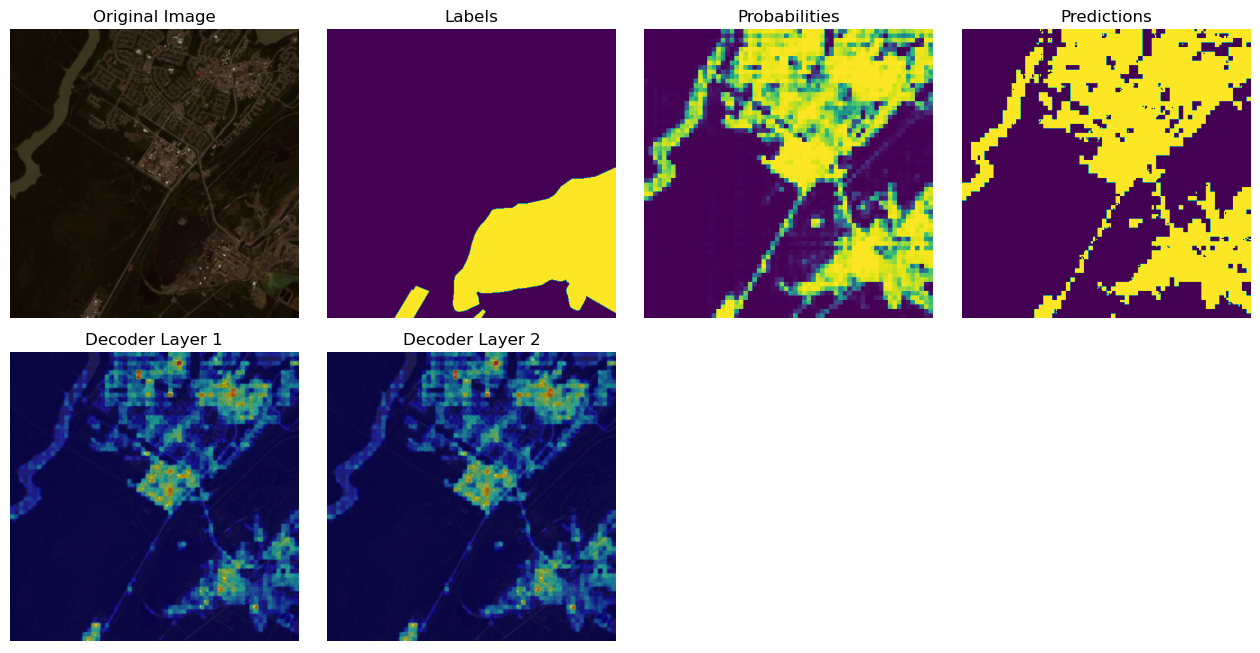

In [18]:
import matplotlib.pyplot as plt
import math

if CLAY:
    encoder_layers = list()
    decoder_layers = list([model_wrapper.model.model.fusion, model_wrapper.model.model.seg_head])
else:
    encoder_layers = list(model.model.encoder.children())
    decoder_layers = list(model.model.decoder.blocks.children())

n_encoder_layers = len(encoder_layers)
n_decoder_layers = len(decoder_layers)

layers = encoder_layers + decoder_layers

print(layers)

num_rows = math.ceil((len(layers)+4) / 4)
fig, axs = plt.subplots(num_rows, 4, figsize=(16, 4*num_rows))

for i, layer in enumerate(layers):
    i += 4
    row = i // 4
    col = i % 4
    if CLAY:
        image, original_image, labels, probas, preds  = visualize_cam_clay(model_wrapper, batch, resized_mask_image, target_layers=layer)
    else:
        image, original_image, labels, probas, preds  = visualize_cam(batch, target_layers=layer)
    axs[row, col].imshow(image)
    title = f"Encoder Layer {i-3}" if i-3 < n_encoder_layers else f"Decoder Layer {i-n_encoder_layers-3}"
    axs[row, col].set_title(title)
    # make closer together
    plt.subplots_adjust(wspace=0.1, hspace=0.1)

# plot the original image
axs[0, 0].imshow(original_image)
axs[0, 0].set_title("Original Image")

# plot the labels and preds
axs[0, 1].imshow(labels)
axs[0, 1].set_title("Labels")
axs[0, 2].imshow(probas)
axs[0, 2].set_title("Probabilities")
axs[0, 3].imshow(preds)
axs[0, 3].set_title("Predictions")

# turn of axes for all subplots
for ax in axs.flat:
    ax.axis("off")

plt.show()

In [ ]:
# input_tensor = batch["pixels"].cuda()
# y = model(input_tensor)

# make_dot(y.mean(), params=dict(model.named_parameters()))